In [ ]:
#! pip install -U tensorboard

In [ ]:
#! cp maps.tar.gz /content/drive/'My Drive'

In [1]:
! python -m tensorboard.main --logdir=/path/to/logs

2020-07-21 18:06:30.079487: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.2.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [4]:
! wget "https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz"
! tar -xf maps.tar.gz > /dev/null

--2020-07-21 17:45:33--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  17.4MB/s    in 15s     

2020-07-21 17:45:49 (15.8 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [2]:
import os
import cv2
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
png_files = glob.glob('maps/train/*.jpg')
png_files[0]

'maps/train/383.jpg'

(600, 1200, 3)


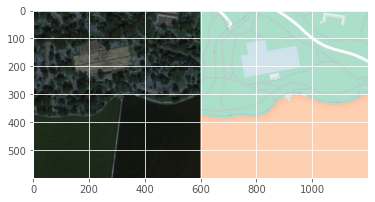

In [4]:
img = cv2.imread(png_files[0],cv2.IMREAD_UNCHANGED)
print(img.shape)
plt.imshow(img)
plt.show()

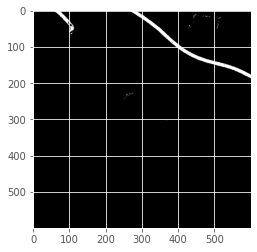

In [5]:
img_t = img[0:600,600:1200]
img_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2GRAY)
ret,thresh1 = cv2.threshold(img_t,245,255,cv2.THRESH_BINARY)
plt.imshow(thresh1,cmap='gray')
plt.show()

In [6]:
ids = next(os.walk("maps/train"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  1096


In [7]:
ids[:10]

['383.jpg',
 '165.jpg',
 '605.jpg',
 '930.jpg',
 '52.jpg',
 '190.jpg',
 '1073.jpg',
 '54.jpg',
 '184.jpg',
 '909.jpg']

In [8]:
im_height = 128
im_width = 128

In [9]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [10]:

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = cv2.imread("maps/train/"+id_, cv2.IMREAD_GRAYSCALE)
    x_img = img_to_array(img[0:600,0:600])
    x_img = resize(x_img, (im_height, im_width, 1))
    # Load masks
    img_t = img[0:600,600:1200] #cv2.cvtColor(imgg, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(img_t,240,255,cv2.THRESH_BINARY)
    mask = resize(thresh1, (im_height, im_width, 1))
    mask = img_to_array(mask)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0


In [45]:
png_files = glob.glob('maps/val/*.jpg')
png_files[0]

'maps/val/383.jpg'

(600, 1200, 3)


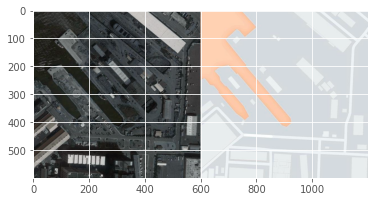

In [46]:
img = cv2.imread(png_files[0],cv2.IMREAD_UNCHANGED)
print(img.shape)
plt.imshow(img)
plt.show()

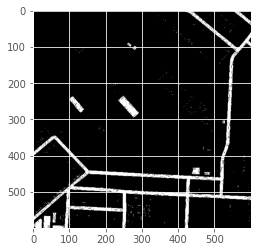

In [48]:
img_t = img[0:600,600:1200]
img_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2GRAY)
ret,thresh1 = cv2.threshold(img_t,240,255,cv2.THRESH_BINARY)
plt.imshow(thresh1,cmap='gray')
plt.show()

In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = cv2.imread("maps/val/"+id_, cv2.IMREAD_GRAYSCALE)
    x_img = img_to_array(img[0:600,0:600])
    x_img = resize(x_img, (im_height, im_width, 1))
    # Load masks
    img_t = img[0:600,600:1200] #cv2.cvtColor(imgg, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(img_t,245,255,cv2.THRESH_BINARY)
    mask = resize(thresh1, (im_height, im_width, 1))
    mask = img_to_array(mask)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0


In [11]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape,y_train.shape)

(986, 128, 128, 1) (986, 128, 128, 1)


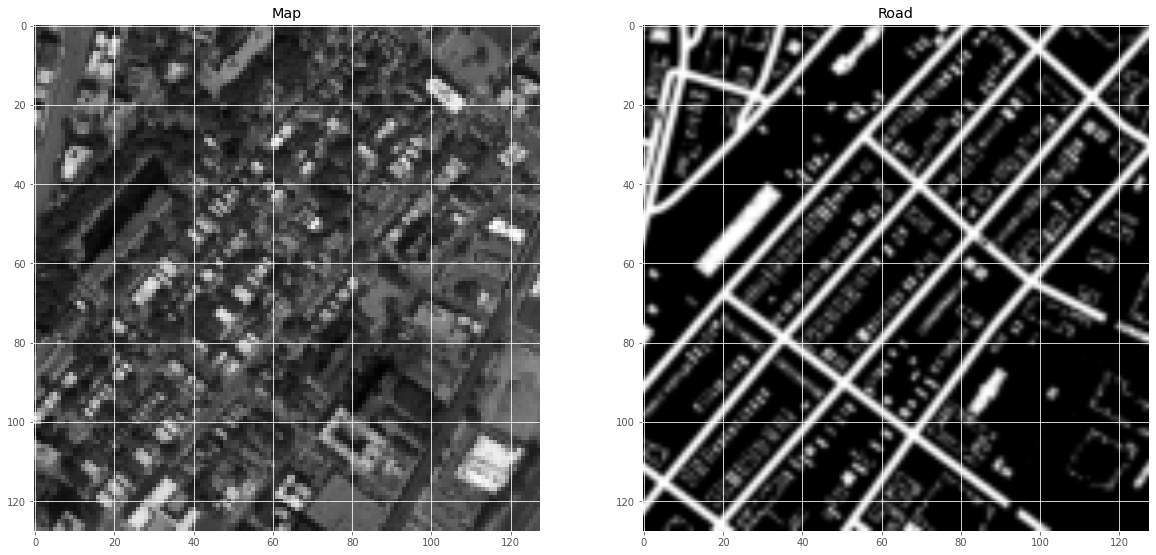

In [12]:


# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
#has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'gray')#, interpolation = 'bilinear')
# if has_mask: # if salt
#     # draw a boundary(contour) in the original image separating salt and non-salt areas
#     ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Map')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Road');



In [13]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [14]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    plot_sample(X_train, y_train, preds_train, preds_train_t)
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [15]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [17]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    ModelCheckpoint('UNetRoads.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [18]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 986 samples, validate on 110 samples
Epoch 1/50
986/986 [==============================] - 9s 9ms/step - loss: 0.4912 - accuracy: 0.4445 - val_loss: 5.7871 - val_accuracy: 0.0832

Epoch 00001: val_loss improved from inf to 5.78709, saving model to UNetRoads.h5
Epoch 2/50
986/986 [==============================] - 3s 3ms/step - loss: 0.2502 - accuracy: 0.5015 - val_loss: 0.5290 - val_accuracy: 0.5068

Epoch 00002: val_loss improved from 5.78709 to 0.52900, saving model to UNetRoads.h5
Epoch 3/50
986/986 [==============================] - 3s 3ms/step - loss: 0.1615 - accuracy: 0.5027 - val_loss: 0.3122 - val_accuracy: 0.5176

Epoch 00003: val_loss improved from 0.52900 to 0.31221, saving model to UNetRoads.h5
Epoch 4/50
986/986 [==============================] - 3s 3ms/step - loss: 0.1212 - accuracy: 0.5028 - val_loss: 0.1176 - val_accuracy: 0.5610

Epoch 00004: val_loss improved from 0.31221 to 0.11758, saving model to UNetRoads.h5
Epoch 5/50
986/986 [==========================

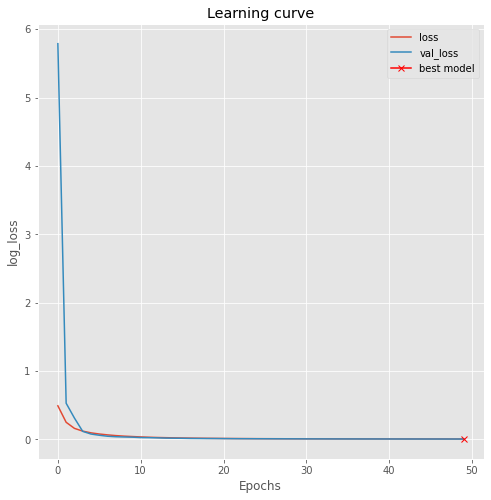

In [19]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [20]:
# load the best model
model.load_weights('UNetRoads.h5')


In [21]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)


110/110 [==============================] - 0s 828us/step


[0.005420143775303255, 0.5619373917579651]

In [22]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

110/110 [==============================] - 0s 857us/step


In [26]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [27]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    #has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    # if has_mask:
    #     ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Map')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Roads')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    # if has_mask:
    #     ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Road Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    # if has_mask:
    #     ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Road Predicted binary');



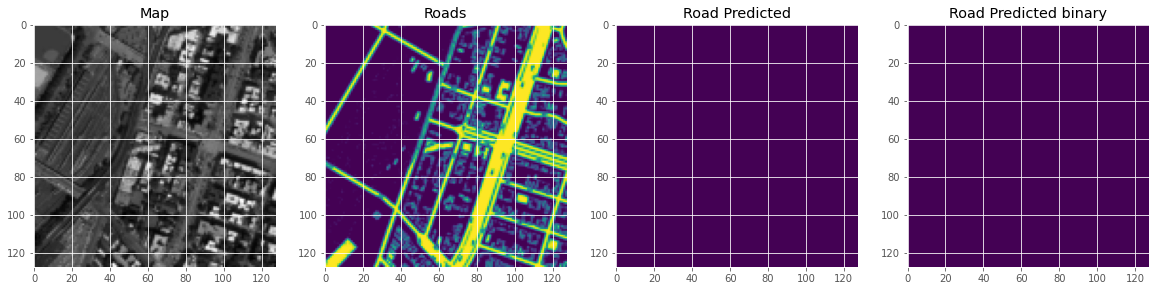

In [28]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

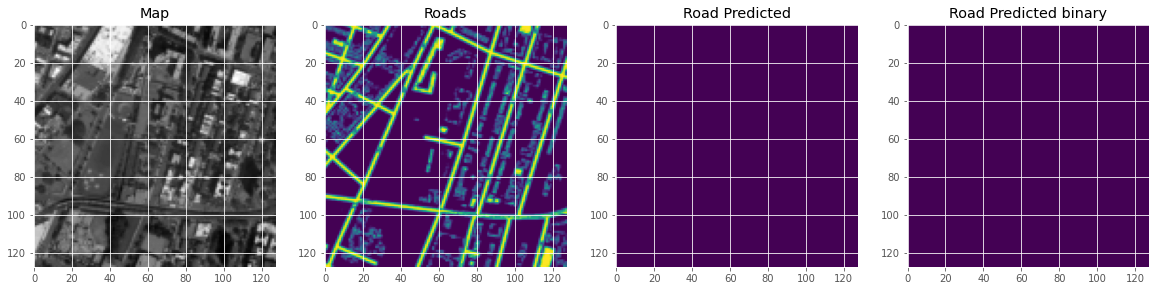

In [29]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

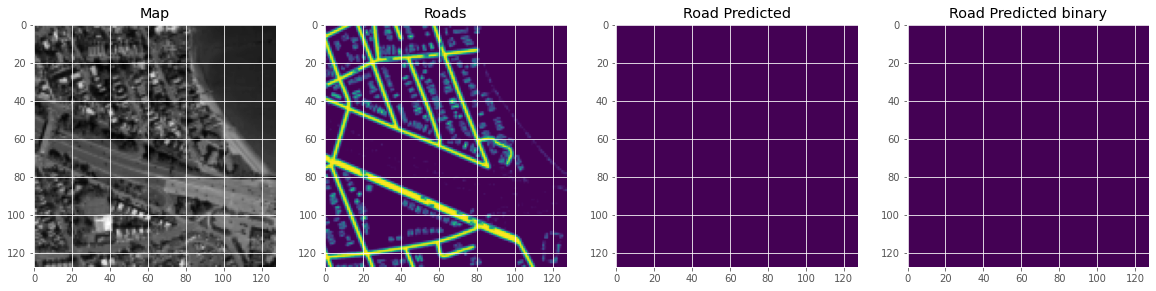

In [30]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

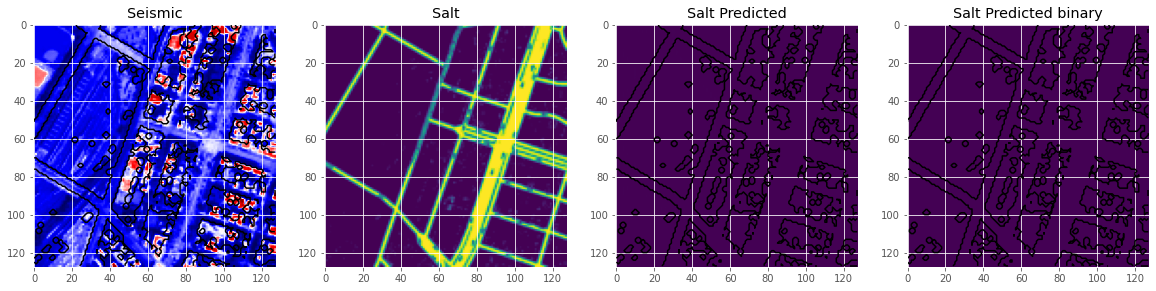

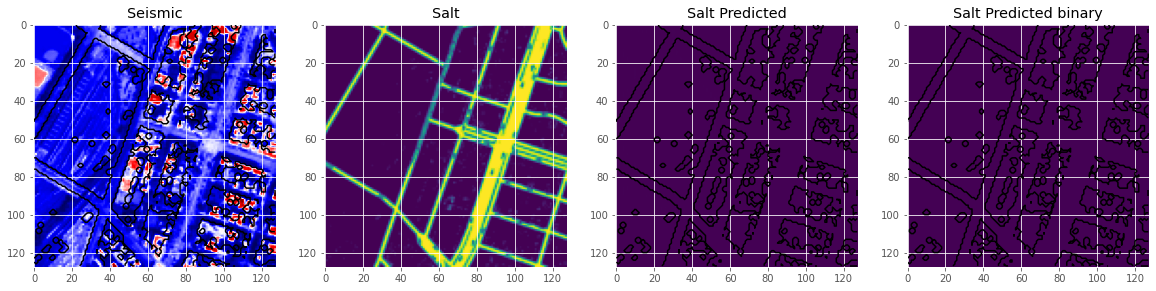

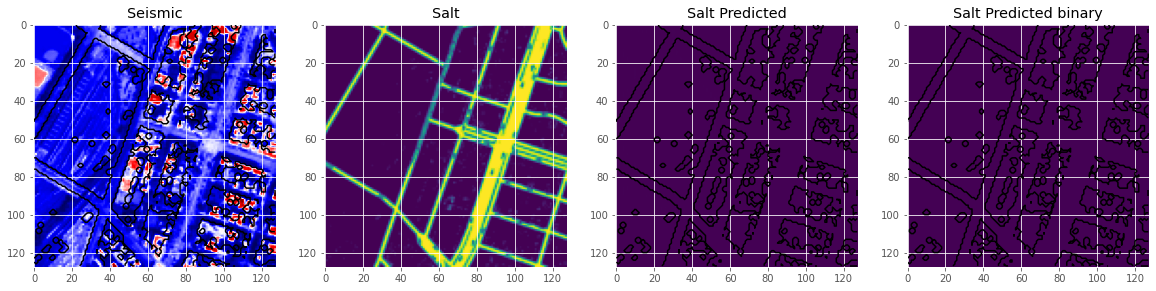

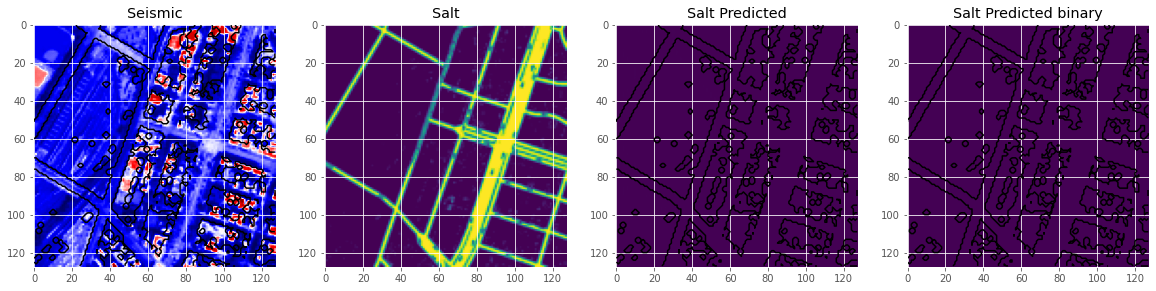

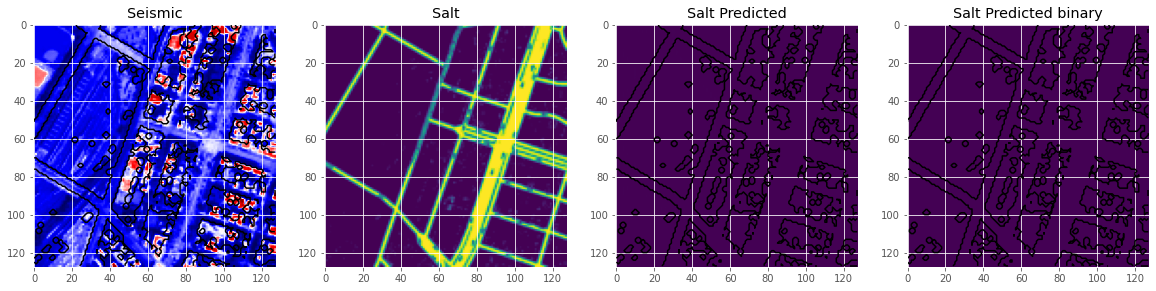

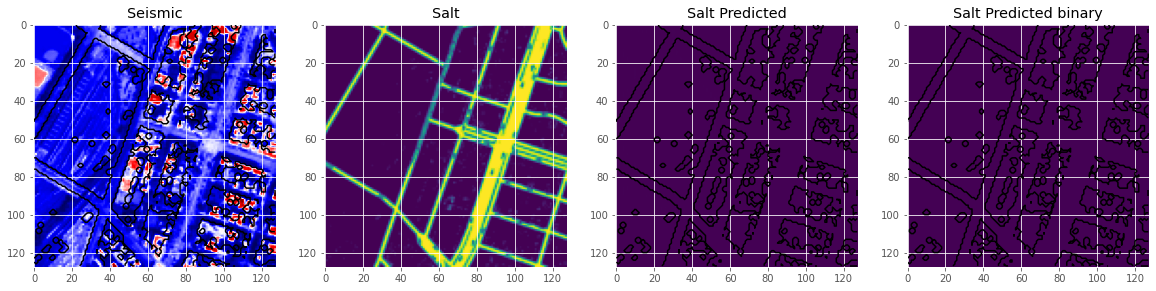

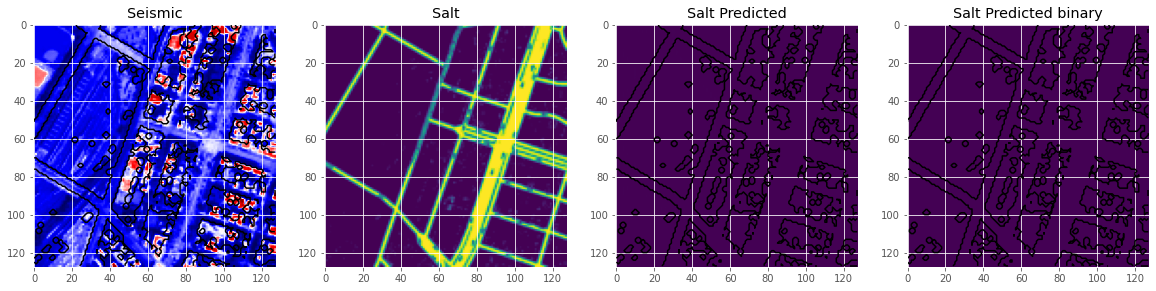

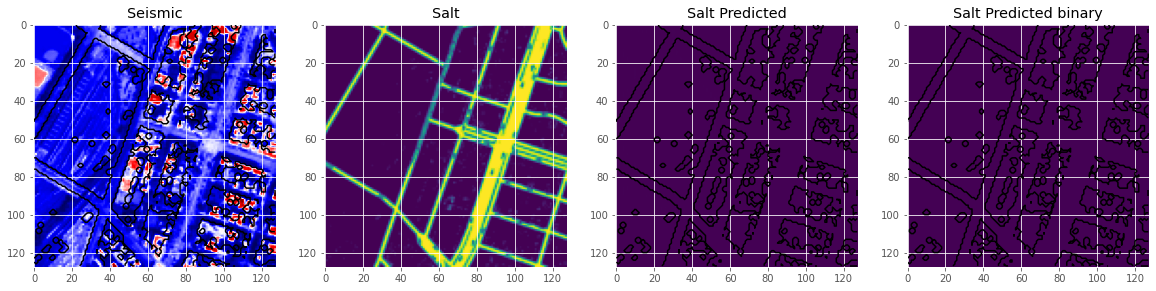

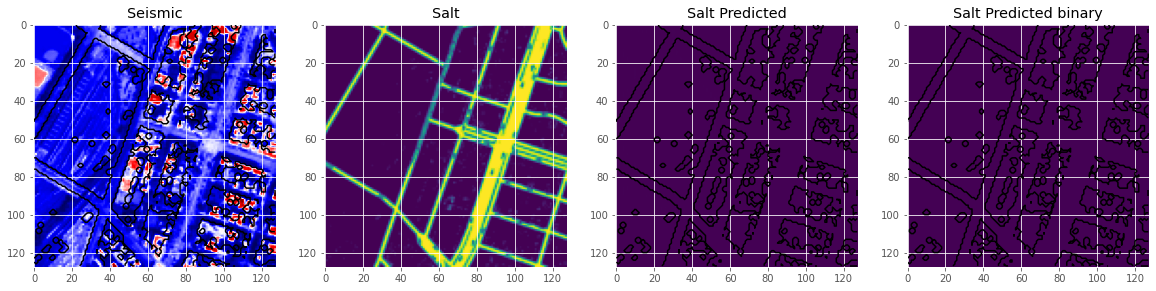

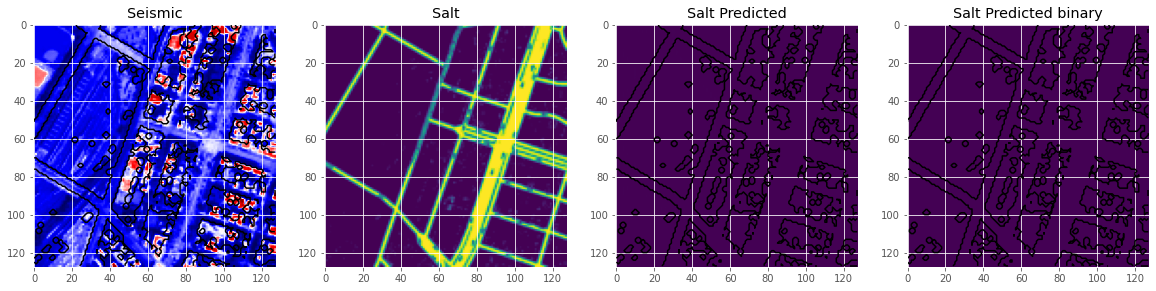

In [30]:
for i in range(10):
  # Check if training data looks all right
  plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)